# Підготовка моделі визначення ознаки придбання телефону у ділянці місцевості

In [1]:
import pandas as pd
import numpy as np
import  seaborn as sns
import  matplotlib.pyplot as plt
import matplotlib as mpl
import folium
from folium.plugins import HeatMap

In [2]:
font_common = {'family': 'Liberation Sans',
               'weight': 'bold',
               'size': 27}
mpl.rc('font', **font_common)

## Завантаження даних: широти, довготи та таргету (без записів з місінгами)

In [3]:
df = pd.read_pickle('spatial_df_wonan.pickle')

In [4]:
df.shape

(200406, 3)

In [5]:
df.dtypes

target     float64
loc_lat    float64
loc_lon    float64
dtype: object

In [6]:
df.head()

target    loc_lat    loc_lon
0     0.0  15.005124  13.438294
1     0.0  14.984766  13.193330
2     0.0  15.302688  12.894874
3     0.0  15.433530  10.478843
4     0.0  15.122221  13.155303

In [7]:
df.describe()

target        loc_lat        loc_lon
count  200406.000000  200406.000000  200406.000000
mean        0.241634      15.145040      12.074151
std         0.428075       0.210484       0.998900
min         0.000000      14.548183       9.612264
25%         0.000000      15.018142      11.684129
50%         0.000000      15.133761      12.280887
75%         0.000000      15.315290      12.894874
max         1.000000      15.652186      13.632522

In [8]:
df.target.value_counts()

0.0    151981
1.0     48425
Name: target, dtype: int64

In [9]:
def plot_fea(df, feature):
    print('**************************\n'
          '          loc_lat\n'
          '**************************')
    fig, ax = plt.subplots(2, 2, figsize=(17, 12))
    sns.boxplot(x=df[feature], y=df['target'], ax=ax[0, 0], orient='h')
    sns.boxplot(data=df[feature], ax=ax[1, 0], orient='h')
    sns.histplot(data=df[feature], ax=ax[0, 1], bins=40)

    pie_lbl = df.target.value_counts().index.map({1: 'Придбали', 0: 'Не придбали'}).tolist()
    ax[1, 1] = plt.pie(x=df.target.value_counts(), labels=pie_lbl,
                       autopct='%0.1F%%',
                       shadow=True,
                       wedgeprops={"edgecolor": "k", 'linewidth': 1},
                       labeldistance=1.2,
                       textprops={'color': "blue"})
    plt.show()
    plt.clf()

**************************
          loc_lat
**************************


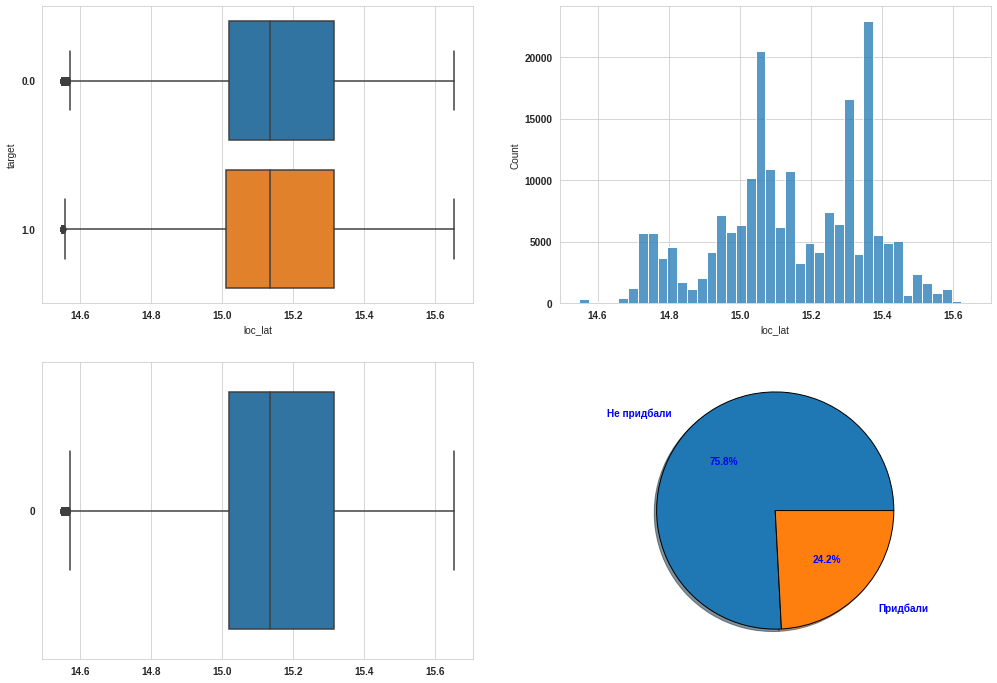

<Figure size 432x288 with 0 Axes>

In [10]:
plot_fea(df, 'loc_lat')

**************************
          loc_lat
**************************


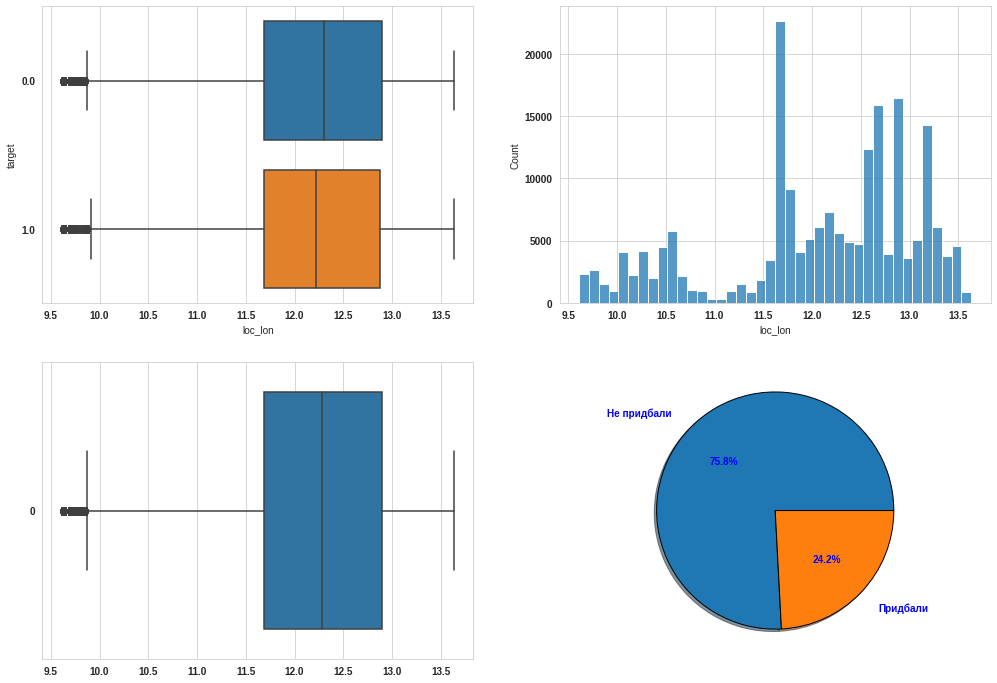

<Figure size 432x288 with 0 Axes>

In [11]:
plot_fea(df, 'loc_lon');

In [12]:
# Нанесення на координатну сітку (загальний огляд розміщення точок у просторі та відносно таргету)
def plot_spatial(df_in, color='coolwarm'):
    df_in.plot(x='loc_lon', y='loc_lat',  kind='scatter',
            figsize=(12,8), c='target', cmap=color, colorbar=False)

In [13]:
# Приведення (масштабування) наданих координат до розташувань на мапі (приблизно)
def spatial_scale(df_in):
    df_in = df_in.copy(deep=True)
    df_lon_min = df_in['loc_lon'].min()
    df_lon_max = df_in['loc_lon'].max()
    df_lat_min = df_in['loc_lat'].min()
    df_lat_max = df_in['loc_lat'].max()
    ukr_border = {'lon_min': 22.0004,
                     'lon_max': 39.1323,
                     'lat_min': 45.2241 ,
                     'lat_max': 52.2245}
    def scale_lon(x):
        X_std = (x - df_lon_min) / (df_lon_max - df_lon_min)
        X_scaled = X_std * (ukr_border['lon_max'] - ukr_border['lon_min']) + ukr_border['lon_min']
        return X_scaled

    def scale_lat(y):
        X_std = (y - df_lat_min) / (df_lat_max - df_lat_min)
        X_scaled = X_std * (ukr_border['lat_max'] - ukr_border['lat_min']) + ukr_border['lat_min']
        return X_scaled

    df_in['loc_lon'] = df_in['loc_lon'].apply(lambda x: scale_lon(x))
    df_in['loc_lat'] = df_in['loc_lat'].apply(lambda x: scale_lat(x))
    return df_in


In [14]:
# Масштабування датафрейму, перестановка колонок
df_scaled = spatial_scale(df.copy(deep=True))
df_scaled = df_scaled[['loc_lat', 'loc_lon', 'target']]

## Візуалізація даних на карті

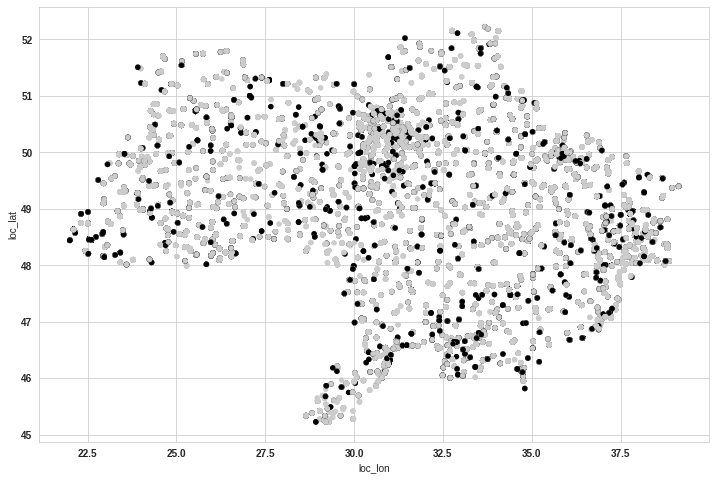

In [15]:
# Всі точки
plot_spatial(df_scaled, color='nipy_spectral_r')

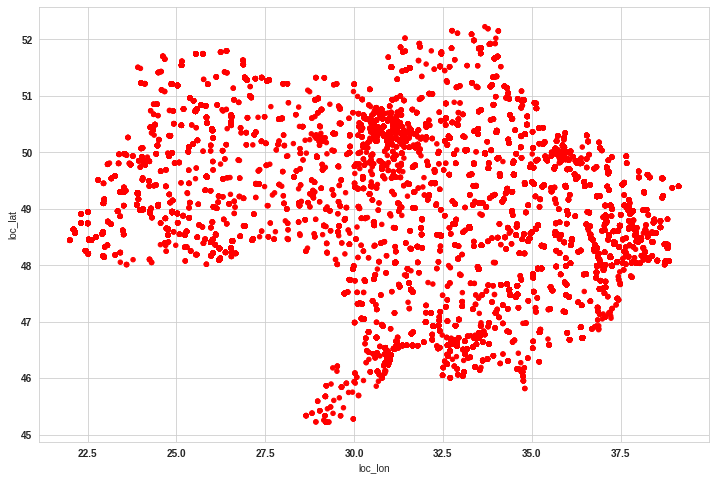

In [16]:
# Тільки ті, що придбали телефон
plot_spatial(df_scaled.loc[df_scaled['target'] == 1], color='hsv')

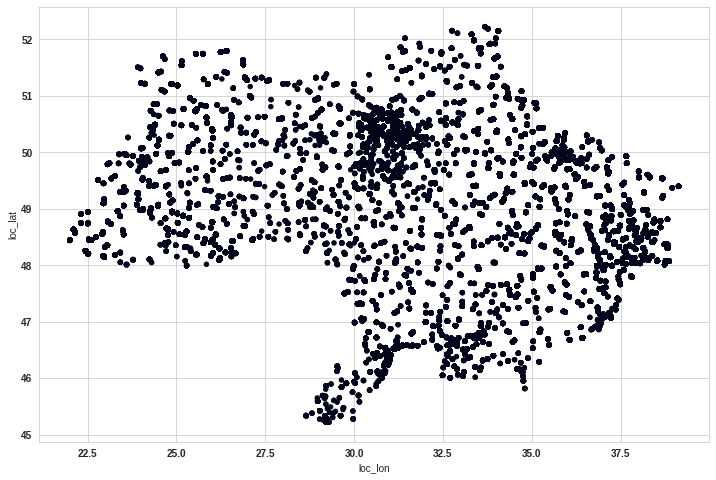

In [17]:
# Тільки ті, що не придбали
plot_spatial(df_scaled.loc[df_scaled['target'] == 0], color='rocket')

In [18]:
# Загальний вигляд покриття (всі точки)
map = folium.Map([50.27072154259162, 28.6578550475771], zoom_start=6)
heat_data = df_scaled[['loc_lat', 'loc_lon']].values.tolist()
HeatMap(heat_data, radius=15, min_opacity=0.25).add_to(map)
map

In [20]:
# map = folium.Map([48.92039514693025, 24.67971641314402], zoom_start=8)

# heat_data = df_scaled.values.tolist()
# HeatMap(heat_data, radius=20).add_to(map)
# map.save('test_folium.html')
# map

In [21]:
from folium.plugins import MarkerCluster

## Побудова моделі

### Тестова модель

In [19]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import RadiusNeighborsRegressor

In [20]:
color_maps = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

<AxesSubplot:xlabel='0', ylabel='1'>

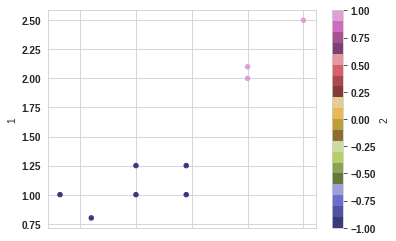

In [21]:
X = np.array([[1.0, 1.0, -1], [1.45, 1.0, -1], [0.6, 0.8, -1],
              [1.0, 1.25, -1], [1.45, 1.25, -1], [0.32, 1.0, -1],
              [2.5, 2.5, 1], [2.0, 2.1, 1], [2.0, 2.0, 1]])
y = np.array([1.0, 1.5, 2.0, 0.0])
z = np.array([[1.1, 1.1], [2.0, 2.0]])
toy_spatial = pd.DataFrame(X)
toy_spatial.plot(x=0, y=1, c=2, kind='scatter', cmap='tab20b')

In [22]:
toy_spatial[[2]]

2
0 -1.0
1 -1.0
2 -1.0
3 -1.0
4 -1.0
5 -1.0
6  1.0
7  1.0
8  1.0

In [23]:
def test_neighbors_regressors_zero_distance(lat_lon, target, radius=0.2):
    ALGORITHMS = {'auto', 'ball_tree', 'kd_tree', 'brute'}
    for algorithm in ALGORITHMS:
        for weights in ['uniform', 'distance']:
            rnn = RadiusNeighborsRegressor(radius=radius,
                                           weights=weights,
                                           algorithm=algorithm)
            rnn.fit(lat_lon, target)
            print(f'АЛГОРИТМ: {algorithm}, ВАГА:{weights}')
            print(f'Результат для тестової точки - {rnn.predict([[2.25, 2.25]])}')
            print()

In [24]:
test_neighbors_regressors_zero_distance(toy_spatial[[0, 1]], toy_spatial[[2]], radius=1.5)

АЛГОРИТМ: ball_tree, ВАГА:uniform
Результат для тестової точки - [[0.2]]

АЛГОРИТМ: ball_tree, ВАГА:distance
Результат для тестової точки - [[0.7240081]]

АЛГОРИТМ: auto, ВАГА:uniform
Результат для тестової точки - [[0.2]]

АЛГОРИТМ: auto, ВАГА:distance
Результат для тестової точки - [[0.7240081]]

АЛГОРИТМ: brute, ВАГА:uniform
Результат для тестової точки - [[0.2]]

АЛГОРИТМ: brute, ВАГА:distance
Результат для тестової точки - [[0.7240081]]

АЛГОРИТМ: kd_tree, ВАГА:uniform
Результат для тестової точки - [[0.2]]

АЛГОРИТМ: kd_tree, ВАГА:distance
Результат для тестової точки - [[0.7240081]]



### Модель на даних з завдання

In [25]:
nnr = RadiusNeighborsRegressor(radius=0.6, # радіус 0.6 надає покриття овалу близько 40х35 км, що відповідає розміру великого міста
                               weights='distance', # вага сусідів зменшується з віддаленням від об'єкту передбачення
                               algorithm='auto',
                               n_jobs=28)


In [26]:
df_scaled.shape

(200406, 3)

In [27]:
df_scaled.tail()

loc_lat    loc_lon  target
205620  50.457060  30.829432     0.0
205621  50.457060  30.829432     0.0
205622  50.419598  30.574611     0.0
205623  50.457060  30.829432     0.0
205624  50.457060  30.829432     0.0

In [28]:
df_minmax_one = df_scaled.copy(deep=True)

In [29]:
df_minmax_one.loc[df_minmax_one['target'] == 0, 'target'] = -1

In [30]:
df_minmax_one.head(20)

loc_lat    loc_lon  target
0   48.121527  38.304619    -1.0
1   47.992437  37.260730    -1.0
2   50.008358  35.988894    -1.0
3   50.838020  25.693235    -1.0
4   48.864030  37.098683    -1.0
5   50.320137  34.811753     1.0
7   48.532339  35.671131     1.0
8   50.004013  31.829581     1.0
9   50.457060  30.829432    -1.0
10  49.930066  24.794085    -1.0
11  50.457060  30.829432     1.0
12  51.143959  34.296931    -1.0
13  47.566914  34.367024     1.0
14  50.457060  30.829432    -1.0
15  47.992437  37.260730    -1.0
16  46.921505  32.229973    -1.0
17  48.480962  38.081353    -1.0
18  50.596352  30.799264    -1.0
19  50.457060  30.829432    -1.0
20  48.469806  34.934454    -1.0

In [31]:
ros = RandomOverSampler()

In [32]:
X_ros, y_ros = ros.fit_resample(df_minmax_one.drop(columns=['target']), df_minmax_one['target'])

In [33]:
X_ros.shape

(303962, 2)

In [34]:
nnr.fit(X_ros, y_ros)

RadiusNeighborsRegressor(n_jobs=28, radius=0.6, weights='distance')

In [ ]:
nnr.predict([[0, 0]])  # точки стосовно яких відсутні сусіди - nan. У разі недостатньої кількості - 0

In [36]:
from datetime import datetime

In [37]:
start_time = datetime.now()
pred = nnr.predict(df_scaled.drop(columns=['target'])[:50000])
print(f'50k points for {datetime.now() - start_time}')

50k points for 0:00:10.111044


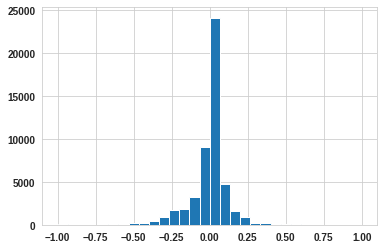

In [38]:
plt.hist(pred, bins=30);

In [37]:
coords_x, coords_y  = 49.16687111067044, 31.847588789608444
print('Кількість сусідів для вибраної точки - ', coords_x, coords_y)
len(nnr.radius_neighbors([[coords_x, coords_y]])[0][0])

Кількість сусідів для вибраної точки -  49.16687111067044 31.847588789608444


/home/matematik/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RadiusNeighborsRegressor was fitted with feature names
  warnings.warn(


1930

In [38]:
class SpatialFeaturing:
    def __init__(self, predictor):
        self.predictor = predictor
        self.ukr_border = {'lon_min': 22.0004,
                           'lon_max': 39.1323,
                           'lat_min': 45.2241 ,
                           'lat_max': 52.2245}
        self.train_border = {'lon_min': 9.612264,
                             'lon_max': 13.632522,
                             'lat_min': 14.548183,
                             'lat_max': 15.652186}
        # тут зазначаються мінімальні та максимальні значення, використані при скейлінгу даних моделі


    def scale_coords_to_real(self, data: pd.Series) -> pd.Series:
        data = data.copy(deep=True)

        if data.name == 'loc_lon':
            df_lon_min = self.train_border['lon_min']
            df_lon_max = self.train_border['lon_max']
            def scale_lon(x):
                X_std = (x - df_lon_min) / (df_lon_max - df_lon_min)
                X_scaled = X_std * (self.ukr_border['lon_max'] - self.ukr_border['lon_min']) + self.ukr_border['lon_min']
                return X_scaled
            data = data.apply(lambda x: scale_lon(x))
            return data

        elif data.name == 'loc_lat':
            df_lat_min = self.train_border['lat_min']
            df_lat_max = self.train_border['lat_max']
            def scale_lat(y):
                X_std = (y - df_lat_min) / (df_lat_max - df_lat_min)
                X_scaled = X_std * (self.ukr_border['lat_max'] - self.ukr_border['lat_min']) + self.ukr_border['lat_min']
                return X_scaled
            data = data.apply(lambda x: scale_lat(x))
            return data

        else:
            assert data.name in ['loc_lon', 'loc_lat'], 'only pd.Series with names - loc_lon or loc_lat'


    def get_spatial_feature(self, row, min_neigh=200):
        lat = row['loc_lat']
        lon = row['loc_lon']
        neigh = self.count_neigh(lat, lon)
        if neigh < min_neigh:
            return 0
        else:
            pred = self.predictor.predict([[lat, lon]])[0]
            if pred > 0.15:
                return 0.15
            elif pred < -0.15:
                return -0.15
            else:
                return pred

    def count_neigh(self, lat, lon):
        return len(self.predictor.radius_neighbors([[lat, lon]])[0][0])


In [39]:
spatial_handler = SpatialFeaturing(nnr)

## Візуалізація роботи моделі

In [64]:
ukr_border = {'lon_min': 22.0004,
              'lon_max': 39.1323,
              'lat_min': 45.2241 ,
              'lat_max': 52.2245}

In [ ]:
spatial_mesh_arr = []
for lat in np.arange(45, 53, 0.1):
    for lon in np.arange(21.5, 39.8, 0.1):
        pred_val = spatial_handler.predictor.predict([[lat, lon]])[0]
        if pred_val > 0.2:
            pred_val = 0.2
        if pred_val < -0.2:
            pred_val = -0.2
        spatial_mesh_arr.append([lat, lon, pred_val])

In [ ]:
df_real_train = pd.read_pickle('df_train_main_converted_wo_spatial.pickle')
df_real_train['loc_lon'] = spatial_handler.scale_coords_to_real(df_real_train['loc_lon'])
df_real_train['loc_lat'] = spatial_handler.scale_coords_to_real(df_real_train['loc_lat'])
df_real_train['spatial'] = df_real_train.apply(lambda x: spatial_handler.get_spatial_feature(x), axis=1)

In [119]:
df_spatial_mesh = pd.DataFrame(spatial_mesh_arr, columns=['loc_lat', 'loc_lon', 'target'])

In [71]:
df_spatial_mesh.describe()

loc_lat      loc_lon       target
count  2001.000000  2001.000000  1410.000000
mean     48.724100    30.500400     0.003238
std       2.092173     4.980368     0.034464
min      45.224100    22.000400    -0.045000
25%      46.974100    26.250400    -0.033304
50%      48.724100    30.500400     0.007555
75%      50.474100    34.750400     0.043558
max      52.224100    39.000400     0.045000

In [ ]:
color_maps = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

In [ ]:
fav_cmaps = ['PiYG', 'coolwarm']

<AxesSubplot:xlabel='loc_lon', ylabel='loc_lat'>

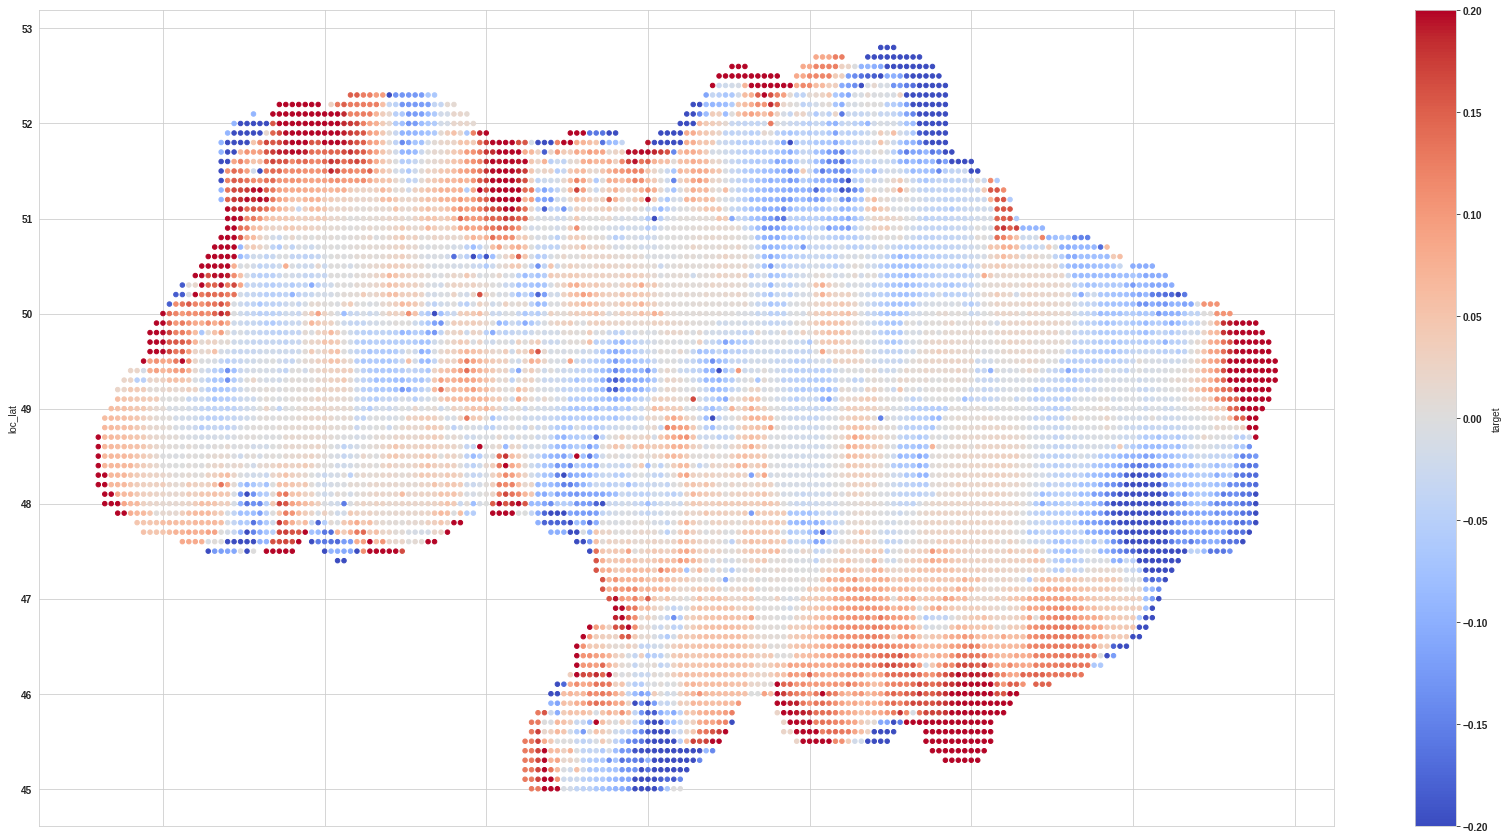

In [120]:
df_spatial_mesh.plot(x='loc_lon', y='loc_lat',  kind='scatter', figsize=(29,15), c='target', cmap='coolwarm', colorbar=True)

## Доповнення конвертованих основних таблиць (train/test) новою фічею

In [42]:
df_real_train.drop(columns=['loc_lat'], inplace=True)
df_real_train.drop(columns=['loc_lon'], inplace=True)
df_real_train.set_index('abon_id', inplace=True, drop=True)

In [43]:
df_real_train.to_pickle('df_train_main_converted_with_spatial.pickle')

In [ ]:
df_real_test = pd.read_pickle('df_test_main_converted_wo_spatial.pickle')
df_real_test['loc_lon'] = spatial_handler.scale_coords_to_real(df_real_test['loc_lon'])
df_real_test['loc_lat'] = spatial_handler.scale_coords_to_real(df_real_test['loc_lat'])
df_real_test['spatial'] = df_real_test.apply(lambda x: spatial_handler.get_spatial_feature(x), axis=1)

In [46]:
df_real_test.to_pickle('df_test_main_converted_with_spatial.pickle')

In [47]:
df_real_test.head()

abon_id  device_id  Balance_uah      TM_ID        lt  loc_cnt_events  \
0  1000003     113518     0.308474  71.714189  4.582053             226   
1  1000007     105734     0.000017  72.007147  4.557137              13   
2  1000023     113242     0.010486  71.703516  4.582767             159   
3  1000026     103779     0.001980  71.692837  4.557782             691   
4  1000027     113278     0.306662  72.205782  4.557782            1798   

   loc_is_obl_center    loc_lat    loc_lon  loc_market_share  ...  \
0                  0  48.204074  22.518226          0.558280  ...   
1                  0  51.696105  34.039210          0.337849  ...   
2                  0  48.996714  37.260674          0.393815  ...   
3                  1  50.915014  34.731723          0.337849  ...   
4                  0  51.661862  33.952567          0.337849  ...   

   device_ios_version_4.0  device_ios_version_5.0  device_ios_version_7.0  \
0                       0                       0                       0   
1                       0                       0                       0   
2                       0                       0                       0   
3                       0                       0                       0   
4                       0                       0                       0   

   device_ios_version_8.0  device_ios_version_9.0  device_ios_version_10.0  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   
3                       0                       0                        0   
4                       0                       0                        0   

   device_ios_version_11.0  device_ios_version_12.0  device_ios_version_13.0  \
0                        0                        0                        0   
1                        0                        0                        0   
2                        0                        0                        0   
3                        0                        0                        0   
4                        0                        0                        0   

    spatial  
0  0.037838  
1 -0.150000  
2  0.045727  
3 -0.026294  
4 -0.150000  

[5 rows x 859 columns]